In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import files
uploaded = files.upload()

Saving review-details.xlsx to review-details.xlsx


In [3]:
df = pd.read_excel('review-details.xlsx')

In [4]:
df.head()

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,Unnamed: 9,...,dimension2,dimension3,dimension4,dimension5,dimension6,dimension7,dimension8,verified_purchase,helpful_review_count,review_hash_id
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,Male Anti-Perspirant Deodorant,COTC Male Anti-Perspirant Deodorant,NaN,NaN,NaN,COTC Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,COTC Yeast Extract,COTC Yeast Extract,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,COTC Yeast Extract,COTC Yeast Extract,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,Beef Stock/Pots/Cubes/Extract/Liquid/Concentrated,Stock Pots,NaN,NaN,NaN,Stock Pots,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,Bathroom Mousse,Bathroom Mousse,NaN,NaN,NaN,NaN,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae


## EDA and preprocessing

In [5]:
df1 = df.rename({'Unnamed: 9': 'review_rating'}, axis=1)

In [6]:
df1.dropna(axis = 1, how ='any').head()

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,manufacturer,market,review_type,parent_review,dimension1,dimension2,dimension8,verified_purchase,helpful_review_count,review_hash_id
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,Unilever Global,UK,Organic,Child,Deos,Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,Unilever Global,UK,Organic,Child,Savoury,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,Unilever Global,UK,Organic,Child,Savoury,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,Unilever Global,UK,Organic,Parent,Savoury,Beef Stock/Pots/Cubes/Extract/Liquid/Concentrated,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,Unilever Global,UK,Organic,Parent,HHC,Bathroom Mousse,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae


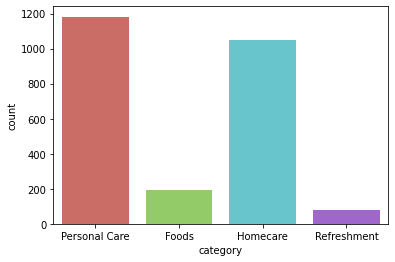

In [7]:
sns.countplot(x='category', data=df, palette='hls')

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   report_date             2501 non-null   datetime64[ns]
 1   online_store            2501 non-null   object        
 2   upc                     2501 non-null   int64         
 3   retailer_product_code   2501 non-null   object        
 4   brand                   2501 non-null   object        
 5   category                2501 non-null   object        
 6   sub_category            2501 non-null   object        
 7   product_description     2501 non-null   object        
 8   review_date             2501 non-null   datetime64[ns]
 9   review_rating           2501 non-null   int64         
 10  review_title            2403 non-null   object        
 11  review_text             2501 non-null   object        
 12  is_competitor           2501 non-null   int64   

5    1848
4     319
1     146
3     107
2      81
Name: review_rating, dtype: int64


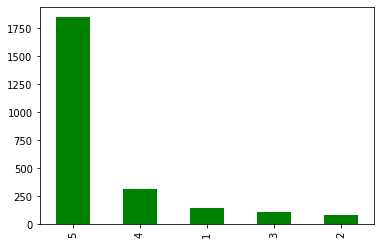

In [9]:
print(df1['review_rating'].value_counts())
df1['review_rating'].value_counts().plot.bar(color='green')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


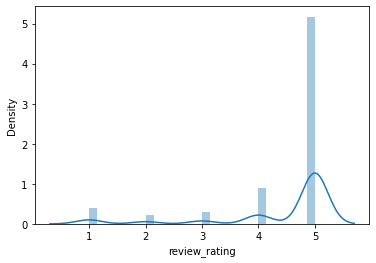

In [10]:
sns.distplot(df1['review_rating'])

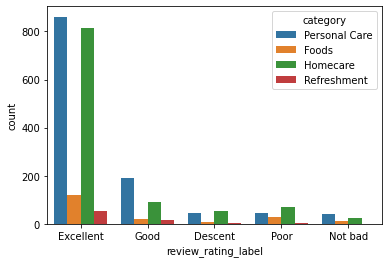

In [31]:
# In this step will get a plot of review_rating across different products 
mapping = {1: 'Poor', 2: 'Not bad', 3: 'Descent', 4: 'Good', 5: 'Excellent'}

df1['review_rating_label'] = df1['review_rating'].map(mapping)

sns.countplot(x='review_rating_label', hue='category', data= df1)

In [11]:
df1['sentiments'] = df1['review_rating'].apply(lambda x: 0 if x == [1, 2] else 1)
df1.head()

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,dimension3,dimension4,dimension5,dimension6,dimension7,dimension8,verified_purchase,helpful_review_count,review_hash_id,sentiments
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,COTC Male Anti-Perspirant Deodorant,NaN,NaN,NaN,COTC Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f,1
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,COTC Yeast Extract,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315,1
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,COTC Yeast Extract,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7,1
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,Stock Pots,NaN,NaN,NaN,Stock Pots,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0,1
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,Bathroom Mousse,NaN,NaN,NaN,NaN,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae,1


In [12]:
# Dependent Features
y = df1['sentiments']

# Independent Features
X = df1.drop('sentiments', axis=1)

In [13]:
messages = X.copy()
messages = messages.reset_index() 

## STEMMING

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stopwords = set(stopwords.words('english'))

In [17]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['review_text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

## TOKENIZATION

In [18]:
voc_size = 15000
max_length = 120
embedding_dim = 16

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=voc_size, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)

In [20]:
sequences = tokenizer.texts_to_sequences(corpus)

embedded_docs = pad_sequences(sequences, maxlen=max_length, padding='post', truncating= 'post')

In [21]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [22]:
X_final.shape, y_final.shape

((2501, 120), (2501,))

## MODEL BUILDING

In [23]:
model = Sequential()
model.add(Embedding(voc_size, embedding_dim, input_length=max_length))
model.add(LSTM(100))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           240000    
                                                                 
 lstm (LSTM)                 (None, 100)               46800     
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 295,377
Trainable params: 295,377
Non-trainable params: 0
_________________________________________________________________
None


### Splitting the data into Train and Test

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

## Model Training

In [25]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
53/53 [==============================] - 9s 119ms/step - loss: 0.1205 - accuracy: 0.9809 - val_loss: 3.3600e-06 - val_accuracy: 1.0000
Epoch 2/10
53/53 [==============================] - 6s 110ms/step - loss: 2.8032e-06 - accuracy: 1.0000 - val_loss: 2.6244e-06 - val_accuracy: 1.0000
Epoch 3/10
53/53 [==============================] - 6s 109ms/step - loss: 2.5584e-06 - accuracy: 1.0000 - val_loss: 2.4871e-06 - val_accuracy: 1.0000
Epoch 4/10
53/53 [==============================] - 6s 108ms/step - loss: 2.4171e-06 - accuracy: 1.0000 - val_loss: 2.3410e-06 - val_accuracy: 1.0000
Epoch 5/10
53/53 [==============================] - 8s 144ms/step - loss: 2.2682e-06 - accuracy: 1.0000 - val_loss: 2.1903e-06 - val_accuracy: 1.0000
Epoch 6/10
53/53 [==============================] - 7s 126ms/step - loss: 2.1172e-06 - accuracy: 1.0000 - val_loss: 2.0397e-06 - val_accuracy: 1.0000
Epoch 7/10
53/53 [==============================] - 6s 119ms/step - loss: 1.9680e-06 - accuracy: 1.0000 

## Performance Matrics and Accuracy

In [26]:
y_predict = ((model.predict(X_test)>0.5).astype('int32'))

26/26 [==============================] - 2s 32ms/step


In [27]:
#confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict)

array([[826]])

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)

1.0

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(y_predict, y_test))
print("Precision : ", precision_score(y_predict, y_test, average = 'weighted'))
print("Recall : ", recall_score(y_predict, y_test, average = 'weighted'))

Accuracy :  1.0
Precision :  1.0
Recall :  1.0
